# Model v18_attention_255

Path images, roughness metric = 1 second ahead, k-means 2, data split within sessions, images with attention region.

## Set-up

In [ ]:
!pip install wandb

In [2]:
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 20kB/s 
     |████████████████████████████████| 4.0MB 49.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
from fastai.vision import *
import pandas as pd
import numpy as np
import os

In [5]:
import wandb
from wandb.fastai import WandbCallback

wandb.init(project='roughness-classifier-4')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Model

#### Load data

In [7]:
path = '/gdrive/My Drive/Labeling/Model'
folder_path = os.path.join(path, 'attention_region', 'v18')
image_path = '/gdrive/My Drive/Labeling/Segmentation/Predictions/AttentionRegion/255'
label_path = '/gdrive/My Drive/Labeling/LabelsCSV'

In [18]:
df = pd.read_csv(os.path.join(label_path, 'attention_region', 'labels_path_validated_mask_split_metric_2.csv'))
df = df.filter(items=['image_mask', 'group_2', 'dataset'])

# Categorical data
df['group_2'] = df['group_2'].astype(int).astype(str)

# Create is_valid column
df['is_valid'] = df['dataset'] == 'valid'

# Training set, filter out dataset column
train = df[df['dataset'] == 'train'].filter(items=['image_mask', 'group_2', 'is_valid'])

# Validation set, filter out dataset column
valid = df[df['dataset'] == 'valid'].filter(items=['image_mask', 'group_2', 'is_valid'])

#### Balance classes

In [19]:
# Training set
group_0 = train[train['group_2'] == '0']
group_1 = train[train['group_2'] == '1']

print(len(group_0))
print(len(group_1))

2838
751


Training and validation set have the same balanced ratio of 1.10.

In [20]:
group_0 = group_0[:827]

train_balanced = group_0.append(group_1)

print(len(train_balanced))
print(len(train_balanced[train_balanced['group_2'] == '0']))
print(len(train_balanced[train_balanced['group_2'] == '1']))

1578
827
751


In [21]:
# Validation set
group_0_v = valid[valid['group_2'] == '0']
group_1_v = valid[valid['group_2'] == '1']

print(len(group_0_v))
print(len(group_1_v))

676
224


In [22]:
group_0_v = group_0_v[:246]

valid_balanced = group_0_v.append(group_1_v)
print(len(valid_balanced))
print(len(valid_balanced[valid_balanced['group_2'] == '0']))
print(len(valid_balanced[valid_balanced['group_2'] == '1']))

470
246
224


In [23]:
df_balanced = train_balanced.append(valid_balanced)
print(len(df_balanced))
print(len(df_balanced[df_balanced['is_valid'] == False]))
print(len(df_balanced[df_balanced['is_valid'] == True]))

2048
1578
470


In [24]:
df_balanced.head()

,image_mask,group_2,is_valid
0,969905035s184ms.png,0,False
1,970588340s260ms.png,0,False
2,969905551s166ms.png,0,False
3,970588244s264ms.png,0,False
4,970328566s709ms.png,0,False


#### DataBunch

The original image size is 3840 x 2160. We resize (squish) to a smaller image with the same aspect ratio (270 x 480, decreased by a factor of 8) [Link](https://fastai1.fast.ai/vision.transform.html#Data-augmentation-details).

In [25]:
bs = 64
# bs = 16    # uncomment this line if you run out of memory

In [26]:
np.random.seed(42)
data = (ImageList
        .from_df(path=image_path, df=df_balanced)
        .split_from_df(col='is_valid')
        .label_from_df(cols='group_2')
        .transform(get_transforms(do_flip=False), size=(270,480))
        .databunch(bs=bs)
        .normalize())

In [27]:
train_x = data.train_ds.x
train_y = data.train_ds.y
valid_x = data.valid_ds.x
valid_y = data.valid_ds.y

print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))

1578 1578
470 470


In [28]:
print(data.classes)

['0', '1']


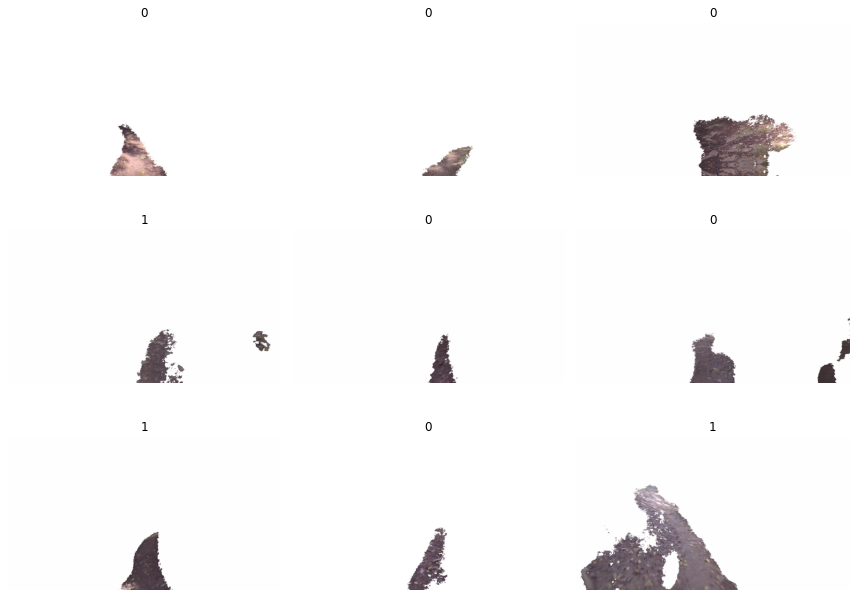

In [29]:
data.show_batch(rows=3, figsize=(12,9))

#### ResNet50

In [30]:
arch = models.resnet50
learn = cnn_learner(data, arch, metrics=[accuracy], callback_fns=WandbCallback)
# learn = cnn_learner(data, arch, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


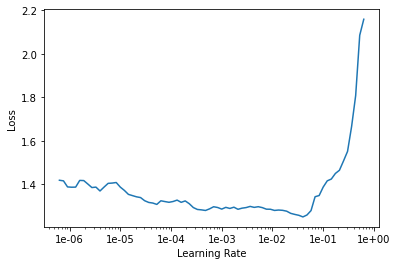

In [32]:
learn.recorder.plot()

In [33]:
lr = 0.01

In [34]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.429065,1.362271,0.553191,08:32
1,1.163871,0.801307,0.557447,06:24
2,0.970388,0.722357,0.597872,06:14
3,0.879774,0.752417,0.568085,06:33
4,0.809849,0.687632,0.602128,06:49


Better model found at epoch 0 with valid_loss value: 1.3622711896896362.
Better model found at epoch 1 with valid_loss value: 0.8013067245483398.
Better model found at epoch 2 with valid_loss value: 0.722357451915741.
Better model found at epoch 4 with valid_loss value: 0.6876317262649536.
Loaded best saved model from /content/wandb/run-20210108_151206-3nbtc6kg/files/bestmodel.pth


In [35]:
learn.save(os.path.join(folder_path, 'v18-attention-255-stage-1'))

In [36]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.814365,1.040495,0.546808,06:56
1,0.852105,0.756194,0.604255,07:01


Better model found at epoch 0 with valid_loss value: 1.0404949188232422.
Better model found at epoch 1 with valid_loss value: 0.7561944723129272.
Loaded best saved model from /content/wandb/run-20210108_151206-3nbtc6kg/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-255-stage-1'))

In [38]:
interp = ClassificationInterpretation.from_learner(learn)

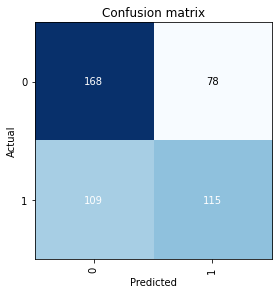

In [39]:
interp.plot_confusion_matrix()

#### Fine-tune

In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-255-stage-1'))

In [41]:
learn.data.batch_size = 16

In [42]:
learn.data.batch_size

16

In [43]:
learn.unfreeze()

In [44]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


Loaded best saved model from /content/wandb/run-20210108_151206-3nbtc6kg/files/bestmodel.pth
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


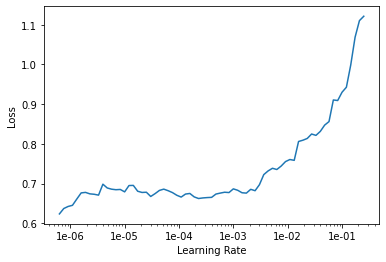

In [45]:
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.686112,0.691973,0.610638,06:59
1,0.719511,0.703148,0.593617,06:54
2,0.669215,0.698224,0.610638,06:39
3,0.675931,0.699782,0.574468,06:50
4,0.676502,0.689716,0.576596,06:33


Better model found at epoch 0 with valid_loss value: 0.6919727325439453.
Better model found at epoch 4 with valid_loss value: 0.6897163391113281.
Loaded best saved model from /content/wandb/run-20210108_151206-3nbtc6kg/files/bestmodel.pth


In [47]:
learn.save(os.path.join(folder_path, 'v18-attention-255-stage-2'))

In [48]:
learn.fit_one_cycle(2, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.674240,0.718563,0.600000,06:44
1,0.640053,0.704181,0.610638,06:57


Better model found at epoch 0 with valid_loss value: 0.718562662601471.
Better model found at epoch 1 with valid_loss value: 0.7041806578636169.
Loaded best saved model from /content/wandb/run-20210108_151206-3nbtc6kg/files/bestmodel.pth


In [ ]:
learn.load(os.path.join(folder_path, 'v18-attention-255-stage-2'))

In [50]:
learn.freeze()

In [51]:
interp = ClassificationInterpretation.from_learner(learn)

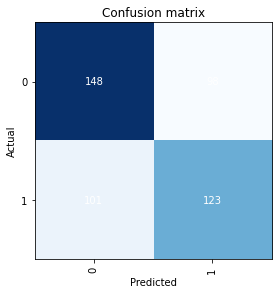

In [52]:
interp.plot_confusion_matrix()

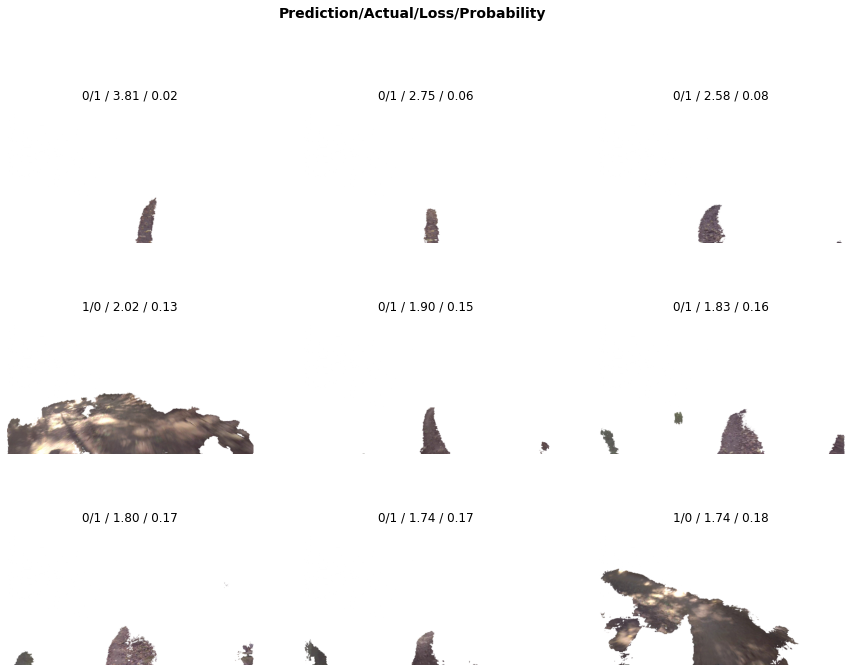

In [53]:
interp.plot_top_losses(9, figsize=(15,11))